In [2]:
import matplotlib.pyplot as plt
from IPython.display import HTML
import seaborn as sns
import gymnasium as gym
import numpy as np
import matplotlib.animation as animation

### ENVIRONMENT SETUP

In [3]:
map_size = 8
map_name = f"{map_size}x{map_size}"
env = gym.make('FrozenLake-v1', is_slippery=True, map_name=map_name)
obs, info =  env.reset()

### SETTING UP GENERIC FUNCTIONS AND VARIABLES

In [ ]:
# Unwrap environment data
plot = env.unwrapped.P

num_states = env.observation_space.n
num_actions = env.action_space.n

theta = 0.0001
gamma = 0.9
alpha = 0.1
epsilon_start = 1.0
min_epsilon = 0.0001
decay_rate = 0.99995
episodes = 1000

# Initialize uniform random policy and state values
policy = np.ones((num_states, num_actions)) / num_actions
state_values = np.zeros(num_states)

### HELPER FUNCTIONS

In [26]:

def run_episode(env, policy):
    """
    Simulates an episode using the given policy and returns the total reward.

    Parameters:
    - env: The environment.
    - policy: The policy to follow (array of action probabilities for each state).

    Returns:
    - total_reward: The total reward accumulated in the episode.
    """
    obs, _ = env.reset()  # Reset environment to start a new episode
    total_reward = 0
    done = False
    max_steps = 200 # Making sure the agent does not get stuck
    steps = 0

    while not done and steps < max_steps:
        steps += 1
        action = np.argmax(policy[obs])  # Pick the best action based on the policy
        obs, reward, done, _, _ = env.step(action)  # Take a step
        total_reward += reward  # Accumulate reward

    return total_reward

def get_terminal_states(env):
    """Finds terminal states in a discrete Gymnasium environment."""
    terminal_states = set()
    goal_states = set()

    for state in range(env.observation_space.n):  # Loop through all states
        all_done = True  # Assume it's terminal unless proven otherwise

        for action in plot[state]:  # Loop through all possible actions

            for prob, next_state, reward, done in plot[state][action]:
                if not done:  # If any action leads to a non-terminal state, it's not terminal
                    all_done = False

        if all_done:
            terminal_states.add(state)

    for s in terminal_states:
        ss = s-1
        for action in plot[ss]:
            for prob, next_state, reward, done in plot[ss][action]:
                if next_state == s and reward == 1:
                    goal_states.add(s)



    return terminal_states, goal_states

terminal_states, goal_states = get_terminal_states(env)
print(f"Terminal states: {terminal_states} and goal states: {goal_states}")

# ---------------------------
# Policy Derivation from Q-table
# ---------------------------
def derive_policy(Q):
    """
    Derive a deterministic policy from the Q-table.
    """
    policy = np.zeros_like(Q)
    for s in range(Q.shape[0]):
        best_action = np.argmax(Q[s])
        policy[s, best_action] = 1.0
    return policy

# ---------------------------
# Policy Evaluation: Run Greedy Episodes
# ---------------------------
def evaluate_policy(env, policy, episodes=100):
    """
    Evaluate a policy by running several episodes and returning total rewards.
    """
    rewards = [run_episode(env, policy) for _ in range(episodes)]
    return rewards


Terminal states: {35, 41, 42, 46, 49, 19, 52, 54, 59, 29, 63} and goal states: {63}


### VISUALIZATION FUNCTIONS

In [6]:

def plot_state_values(V, size=map_size, title="State Value Function"):
    """
    Plots a heatmap of state values.

    Parameters:
    - V: State values (1D or 2D array)
    - size: Grid size (assuming square grid)
    - title: Title of the plot
    """
    V_matrix = np.array(V).reshape(size, size)  # Reshape into a grid
    plt.figure(figsize=(6, 5))
    sns.heatmap(V_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title(title)
    plt.xlabel("X-axis (Columns)")
    plt.ylabel("Y-axis (Rows)")
    plt.show()

def animate_state_value_evolution(value_history, size=map_size, title="State Value Evolution"):
    """
    Animates the evolution of state values over iterations.

    Parameters:
    - value_history: List of state value arrays over iterations
    - size: Grid size (assuming square grid)
    - title: Title of the animation

    Returns:
    - HTML animation object (for Jupyter Notebooks)
    """
    fig, ax = plt.subplots(figsize=(6, 5))

    def update(frame):
        ax.clear()
        V_matrix = np.array(value_history[frame]).reshape(size, size)
        sns.heatmap(V_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, ax=ax, cbar=False)
        ax.set_title(f"{title} - Iteration {frame+1}")

    ani = animation.FuncAnimation(fig, update, frames=len(value_history), repeat=False)

    # Display animation correctly
    plt.close(fig)  # Prevent duplicate static images
    return HTML(ani.to_jshtml())  # Only for Jupyter

def visualize_policy(policy, size=map_size, title="Policy Visualization"):
    """
    Visualizes the optimal policy using arrows.

    Parameters:
    - policy: 2D array of action probabilities
    - size: Grid size (assuming square grid)
    - title: Title of the visualization
    """
    action_mapping = {0: '←', 1: '↓', 2: '→', 3: '↑'}
    policy_actions = [action_mapping[np.argmax(row)] for row in policy]

    print(title)
    print(np.array(policy_actions).reshape(size, size))


# Action symbols for policy visualization
ACTION_SYMBOLS = ['←', '↓', '→', '↑']  # Left, Down, Right, Up

def plot_state_values(V, size=map_size, title="State Value Function"):
    """
    Plots a heatmap of state values.

    Parameters:
    - V: State values (1D or 2D array)
    - size: Grid size (assuming square grid)
    - title: Title of the plot
    """
    V_matrix = np.array(V).reshape(size, size)
    plt.figure(figsize=(6, 5))
    sns.heatmap(V_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title(title)
    plt.xlabel("X-axis (Columns)")
    plt.ylabel("Y-axis (Rows)")
    plt.show()

def animate_state_value_evolution(value_history, size=map_size, title="State Value Evolution"):
    """
    Animates the evolution of state values over iterations.

    Parameters:
    - value_history: List of state value arrays over iterations
    - size: Grid size (assuming square grid)
    - title: Title of the animation

    Returns:
    - HTML object containing the animation (for Jupyter Notebooks)
    """
    fig, ax = plt.subplots(figsize=(6, 5))

    def update(frame):
        ax.clear()
        V_matrix = np.array(value_history[frame]).reshape(size, size)
        sns.heatmap(V_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, ax=ax, cbar=False)
        ax.set_title(f"{title} - Iteration {frame+1}")

    # Store animation in a variable to avoid garbage collection issues
    ani = animation.FuncAnimation(fig, update, frames=len(value_history), repeat=False)

    # Close static image display to prevent duplicate figures
    plt.close(fig)

    return HTML(ani.to_jshtml())  # Works in Jupyter Notebooks

def plot_policy(policy, env, size=map_size, title="Optimal Policy"):
    """
    Visualizes the optimal policy on a grid environment.

    Parameters:
    - policy: 2D array of action probabilities
    - env: OpenAI Gym environment with a defined grid structure
    - size: Grid size (assuming square grid)
    - title: Title of the visualization
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xticks(np.arange(size + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(size + 1) - 0.5, minor=True)
    ax.grid(which="minor", color="gray", linestyle='-', linewidth=1.5)
    ax.tick_params(which="minor", size=0)
    ax.set_xticks([])
    ax.set_yticks([])

    env_unwrapped = env.unwrapped

    for y in range(size):
        for x in range(size):
            state = y * size + x
            cell = env_unwrapped.desc[y, x]

            if cell == b'G':  # Goal
                ax.text(x, y, 'G', ha='center', va='center', fontsize=20, fontweight='bold', color='green')
            elif cell == b'H':  # Hole
                ax.text(x, y, 'H', ha='center', va='center', fontsize=20, fontweight='bold', color='red')
            else:  # Normal state, show best action
                best_action = np.argmax(policy[state])
                action_text = ACTION_SYMBOLS[best_action]
                ax.text(x, y, action_text, ha='center', va='center', fontsize=30, fontweight='bold', color='black')

    ax.set_title(title)
    plt.gca().invert_yaxis()
    plt.show()

def running_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_rewards(data, window_size):
    smoothed_rewards = running_average(data, window_size)
    plt.plot(smoothed_rewards)
    plt.xlabel("Episode")
    plt.ylabel("Success Rate")
    plt.title("Smoothed Episode Success Rate")
    plt.grid()
    plt.show()

def plot_steps(data, window_size):
    smoothed_steps = running_average(data, window_size)
    plt.plot(smoothed_steps)
    plt.xlabel("Episode")
    plt.ylabel("Steps taken")
    plt.title("Progression of the amount of steps through learning")
    plt.grid()
    plt.show()

def plot_cumsum(data):
    cumulative_success = np.cumsum(data)
    plt.plot(cumulative_success)
    plt.xlabel("Episode")
    plt.ylabel("Total Successes")
    plt.title("Cumulative Successes over Time")
    plt.show()


### DYNAMIC PROGRAMMING ALGORITHMS

In [7]:
def policy_evaluation(policy, gamma, theta, state_values):
    delta = theta * 2

    while delta > theta:
        delta = 0
        new_state_values = np.zeros_like(state_values)

        for state in range(num_states):
            new_s = 0
            for action in range(num_actions):
                transition_list = plot[state][action]
                for trans_prob, next_state, reward, done in transition_list:
                    new_s += policy[state, action] * trans_prob * (reward + gamma * state_values[next_state])

            delta = max(delta, np.abs(new_s - state_values[state]))
            new_state_values[state] = new_s

        state_values[:] = new_state_values
    return state_values

def policy_improvement(policy, state_values, gamma):
    new_policy = np.zeros_like(policy)

    for state in range(num_states):
        action_values = np.zeros(num_actions)
        for action in range(num_actions):
            transition_list = plot[state][action]
            for trans_prob, next_state, reward, done in transition_list:
                action_values[action] += trans_prob * (reward + gamma * state_values[next_state])

        best_actions = np.where(action_values == np.max(action_values))[0]
        new_policy[state, best_actions] = 1.0 / len(best_actions)

    return new_policy

def policy_iteration(env, gamma, theta):
    policy = np.ones((num_states, num_actions)) / num_actions
    state_values = np.zeros(num_states)
    state_value_history = []
    reward_history = []

    for _ in range(1000):
        state_values = policy_evaluation(policy, gamma, theta, state_values.copy())
        state_value_history.append(state_values.copy())
        new_policy = policy_improvement(policy, state_values, gamma)

        # Inside policy_iteration function
        total_reward = run_episode(env, new_policy)
        reward_history.append(total_reward)

        if np.array_equal(policy, new_policy):
            break
        policy = new_policy.copy()

    return policy, state_values, state_value_history, reward_history

# Value Iteration Function
def value_iteration(env, gamma, theta):
    state_values = np.zeros(num_states)  # Initialize state values
    value_history = []
    delta = theta * 2

    while delta > theta:
        delta = 0
        new_state_values = np.zeros_like(state_values)

        for state in range(num_states):
            action_values = np.zeros(num_actions)
            for action in range(num_actions):
                transition_list = plot[state][action]
                for trans_prob, next_state, reward, done in transition_list:
                    action_values[action] += trans_prob * (reward + gamma * state_values[next_state])

            best_action_value = np.max(action_values)  # Choose the best action value
            delta = max(delta, np.abs(best_action_value - state_values[state]))
            new_state_values[state] = best_action_value

        state_values[:] = new_state_values
        value_history.append(state_values.copy())

        if delta < theta:  # Stop when values converge
            break

    # Derive policy from final state values
    policy = np.zeros((num_states, num_actions))
    for state in range(num_states):
        action_values = np.zeros(num_actions)
        for action in range(num_actions):
            transition_list = plot[state][action]
            for trans_prob, next_state, reward, done in transition_list:
                action_values[action] += trans_prob * (reward + gamma * state_values[next_state])

        best_actions = np.where(action_values == np.max(action_values))[0]
        policy[state, best_actions] = 1.0 / len(best_actions)

    return policy, state_values, value_history


# Helper function to pretty-print the grid
def print_grid(title, grid):
    print(title)
    print(np.array2string(np.array(grid), formatter={'float_kind':lambda x: f"{x:6.3f}"}))
    print()

# Run Policy Iteration
policy_pi, state_values_pi, state_value_history_pi, reward_history_pi = policy_iteration(env, gamma, theta)

# Run Value Iteration
policy_vi, state_values_vi, value_history_vi = value_iteration(env, gamma, theta)


### DYNAMIC PROGRAMMING - VISUALISATION

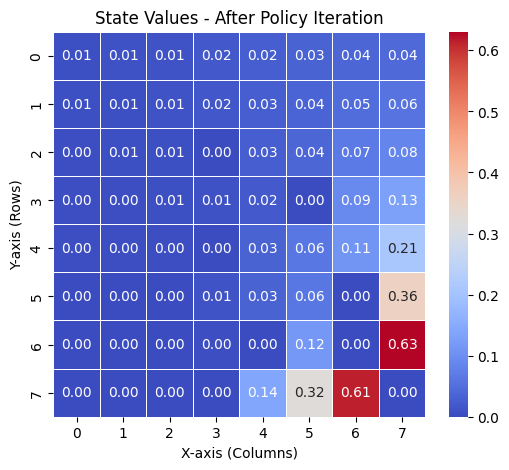

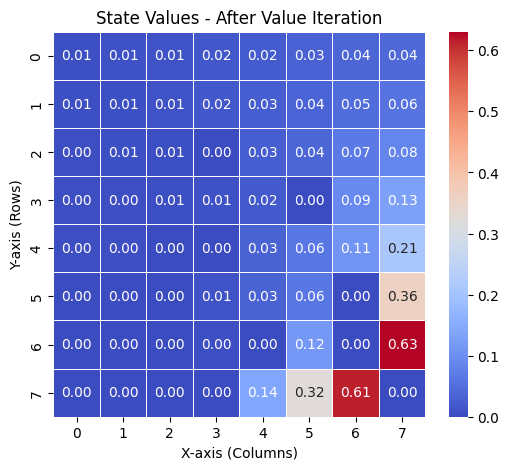

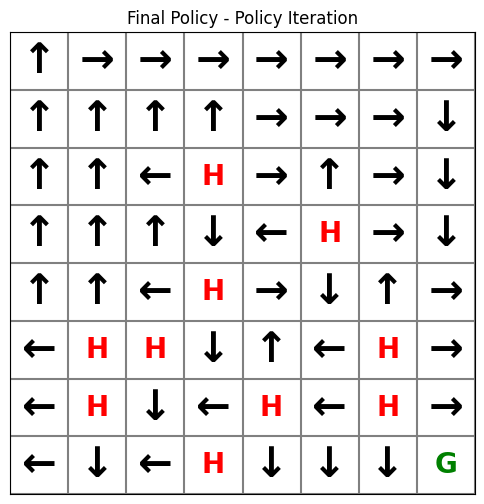

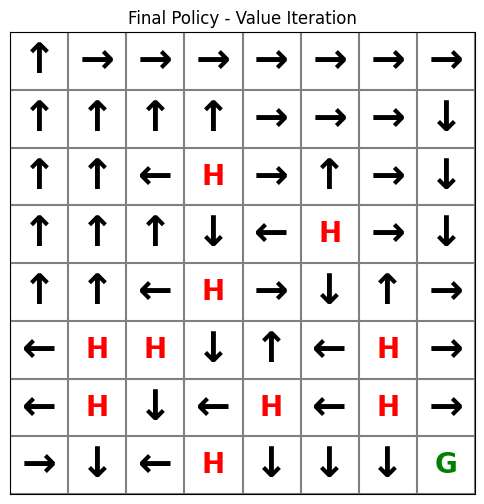

In [8]:
# Plot state values after policy and value iteration
plot_state_values(state_values_pi, title="State Values - After Policy Iteration")
plot_state_values(state_values_vi, title="State Values - After Value Iteration")

# Animate state value evolution
display(animate_state_value_evolution(value_history_vi, title="State Value Evolution - Value Iteration"))

# Visualize policies
plot_policy(policy_pi, env, title="Final Policy - Policy Iteration")
plot_policy(policy_vi, env, title="Final Policy - Value Iteration")

### MONTE CARLO FUNCTIONS

In [30]:
def monte_carlo_pred(env, num_episodes=1000, gamma=gamma):
    """
    First-visit Monte Carlo Prediction: returns estimated state values.
    """
    values = np.zeros(num_states)
    returns = {state: [] for state in range(num_states)}
    for _ in range(num_episodes):
        state, info = env.reset()
        episode = []
        done = False
        steps = 0
        # Generate an episode using random actions
        while not done and steps <= 100:
            action = np.random.randint(num_actions)
            new_state, reward, done, _, _ = env.step(action)
            steps += 1
            episode.append((state, reward))
            state = new_state
        G = 0
        visited = set()
        # Process episode in reverse for first-visit MC
        for state, reward in reversed(episode):
            G = gamma * G + reward
            if state not in visited:
                returns[state].append(G)
                values[state] = np.mean(returns[state])
                visited.add(state)
    return values

def monte_carlo_control(env, num_episodes=5000, gamma=gamma, epsilon=0.1):
    """
    On-policy First-Visit Monte Carlo Control using an ε-soft policy.
    Returns the estimated Q-values.
    """
    Q = np.zeros((num_states, num_actions))
    returns = { (s, a): [] for s in range(num_states) for a in range(num_actions) }

    def create_epsilon_soft_policy(state):
        # If Q[state] is all zeros, return a uniform random policy
        if np.all(Q[state] == 0):
            return np.ones(num_actions) / num_actions
        best_action = np.argmax(Q[state])
        policy = np.ones(num_actions) * (epsilon / num_actions)
        policy[best_action] += (1.0 - epsilon)
        return policy

    for _ in range(num_episodes):
        episode = []
        state, info = env.reset()
        done = False
        steps = 0
        # Generate an episode using the current ε-soft policy
        while not done and steps <= 100:
            policy_s = create_epsilon_soft_policy(state)
            action = np.random.choice(np.arange(num_actions), p=policy_s)
            new_state, reward, done, _, _ = env.step(action)
            steps += 1
            episode.append((state, action, reward))
            state = new_state

        G = 0
        visited_state_action = set()
        # Process episode in reverse for first-visit MC
        for state, action, reward in reversed(episode):
            G = gamma * G + reward
            if (state, action) not in visited_state_action:
                visited_state_action.add((state, action))
                returns[(state, action)].append(G)
                Q[state, action] = np.mean(returns[(state, action)])
    return Q



Monte Carlo Prediction:


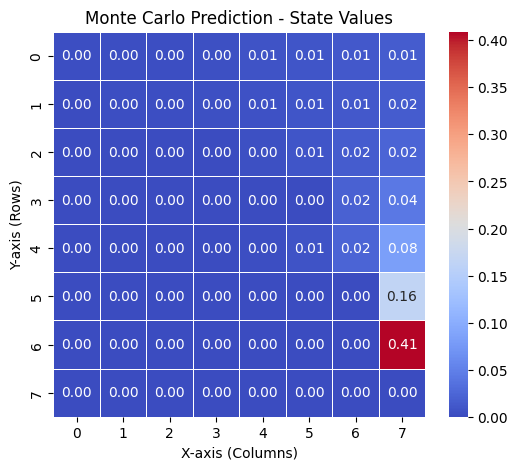


Monte Carlo Control:


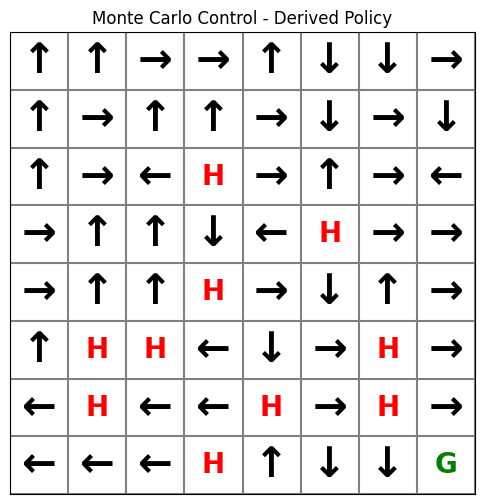

In [53]:
# Run Monte Carlo Prediction
print("\nMonte Carlo Prediction:")
mc_state_values = monte_carlo_pred(env, num_episodes=20000, gamma=0.999)
# print("Monte Carlo State Values:\n", mc_state_values)

# Visualize Monte Carlo State Values
plot_state_values(mc_state_values, title="Monte Carlo Prediction - State Values")

# Run Monte Carlo Control
print("\nMonte Carlo Control:")
mc_Q = monte_carlo_control(env, num_episodes=20000, gamma=0.999, epsilon=0.5)
# print("Monte Carlo Control Q-values:\n", mc_Q)

# Derive a greedy policy from the learned Q-values
mc_policy = np.zeros((num_states, num_actions))
for s in range(num_states):
    best_action = np.argmax(mc_Q[s])
    mc_policy[s, best_action] = 1.0

# Visualize the policy
plot_policy(mc_policy, env, title="Monte Carlo Control - Derived Policy")


In [59]:
r = evaluate_policy(env, mc_policy, episodes=1000)
sum(r)

647.0

In [ ]:
# Visualize Monte Carlo State Values
plot_state_values(mc_state_values, title="Monte Carlo Prediction - State Values")

# Run Monte Carlo Control
print("\nMonte Carlo Control:")
mc_Q = monte_carlo_control(env, num_episodes=100000, gamma=gamma, epsilon=0.1)
# print("Monte Carlo Control Q-values:\n", mc_Q)

# Derive a greedy policy from the learned Q-values
mc_policy = np.zeros((num_states, num_actions))
for s in range(num_states):
    best_action = np.argmax(mc_Q[s])
    mc_policy[s, best_action] = 1.0

# Visualize the policy
plot_policy(mc_policy, env, title="Monte Carlo Control - Derived Policy")

### TEMPORAL DIFFERENCE LEARNING

In [42]:
def initialize_q(env, init_value=0.0):
    """
    Initialize Q-table as a NumPy array with shape (num_states, num_actions).
    """
    num_states = env.observation_space.n
    num_actions = env.action_space.n
    return np.ones((num_states, num_actions)) * init_value

def decay_epsilon(epsilon, min_epsilon=min_epsilon, decay_rate=decay_rate):
    """
    Exponential decay of epsilon.
    """
    return max(min_epsilon, epsilon * decay_rate)

def epsilon_greedy(Q, state, epsilon):
    """
    Select an action using an ε-greedy policy.
    """
    num_actions = Q.shape[1]
    if np.random.rand() < epsilon:
        return np.random.choice(num_actions)
    else:
        return np.argmax(Q[state])

# ---------------------------
# TD(0) Prediction (State-Value Estimation)
# ---------------------------
def td_0_prediction(env, policy, alpha=alpha, gamma=gamma, episodes=episodes):
    """
    TD(0) prediction to estimate state values V(s) for a fixed policy.
    """
    num_states = env.observation_space.n
    V = np.zeros(num_states)
    num_actions = env.action_space.n  # Not used directly but clarifies env dimensions.
    total_rewards = []
    
    for ep in range(episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = np.random.choice(np.arange(num_actions), p=policy[obs])
            next_obs, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            done = terminated or truncated
            V[obs] += alpha * (reward + gamma * V[next_obs] - V[obs])
            obs = next_obs
        total_rewards.append(total_reward)
    return (V, total_rewards)

# ---------------------------
# Expected SARSA (On-Policy TD Control)
# ---------------------------
def expected_sarsa(env, alpha=alpha, gamma=gamma, epsilon=epsilon_start,
                   episodes=episodes):
    """
    Expected SARSA for learning Q-values using an ε-greedy policy.
    """
    num_states = env.observation_space.n
    num_actions = env.action_space.n
    Q = initialize_q(env, init_value=1.0)
    total_rewards = []
    episode_steps = []
    
    for ep in range(episodes):
        obs, _ = env.reset()
        done = False
        action = epsilon_greedy(Q, obs, epsilon)
        total_reward = 0
        steps = 0
        while not done:
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            total_reward += reward
            steps += 1
            
            # Calculate expected Q for next state under ε-soft policy.
            best_action = np.argmax(Q[next_obs])
            expected_Q = sum(
                ((1 - epsilon + epsilon / num_actions) if a == best_action else (epsilon / num_actions)) * Q[next_obs, a]
                for a in range(num_actions)
            )

            Q[obs, action] += alpha * (reward + gamma * expected_Q - Q[obs, action])
            action = epsilon_greedy(Q, next_obs, epsilon)
            obs = next_obs
            
        total_rewards.append(total_reward)
        episode_steps.append(steps)
        epsilon = decay_epsilon(epsilon)

    return (Q, total_rewards, episode_steps)

# ---------------------------
# Q-Learning (Off-Policy TD Control)
# ---------------------------
def q_learning(env, alpha=alpha, gamma=gamma, epsilon=epsilon_start,
               episodes=episodes):
    """
    Q-Learning algorithm for off-policy control.
    """
    num_states = env.observation_space.n
    Q = initialize_q(env, init_value=0.0)

    episode_steps = []
    total_rewards = []
    for ep in range(episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        steps = 0

        while not done:
            action = epsilon_greedy(Q, obs, epsilon)
            next_obs, reward, terminated, truncated, _ = env.step(action)
            steps += 1
            total_reward += reward
            done = terminated or truncated
            best_next_action = np.argmax(Q[next_obs])
            Q[obs, action] += alpha * (reward + gamma * Q[next_obs, best_next_action] - Q[obs, action])
            obs = next_obs

        episode_steps.append(steps)
        epsilon = decay_epsilon(epsilon)
        total_rewards.append(total_reward)

    return (Q, total_rewards, episode_steps)

### TD(0)

In [46]:
gamma_td0 = 0.999           # TD(0): discount factor
episodes_td0 = 1000        # TD(0): number of episodes
alpha_td0 = 0.05            # TD(0): learning rate

V_td0, episode_rewards = td_0_prediction(env, policy, alpha=alpha_td0, gamma=gamma_td0, episodes=episodes_td0)

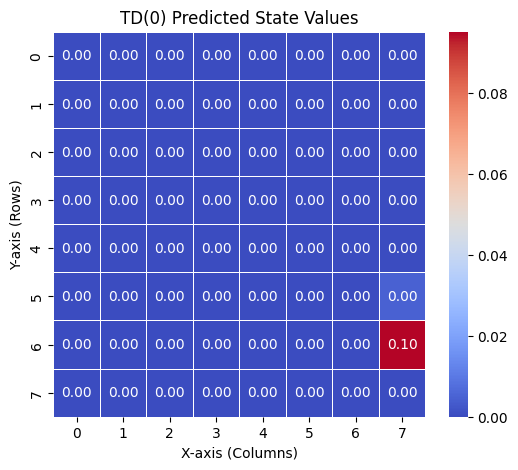

In [48]:
plot_state_values(V_td0, title="TD(0) Predicted State Values")


### SARSA

In [45]:
# Adjust hyperparameters for Expected SARSA
gamma_adjusted = 0.999
episodes_adjusted = 100000
epsilon_initial = 0.45
alpha_adjusted = 0.05

Q_expected, episode_rewards, steps = expected_sarsa(env, alpha=alpha, gamma=gamma_adjusted,
                            epsilon=epsilon_initial, episodes=episodes_adjusted)

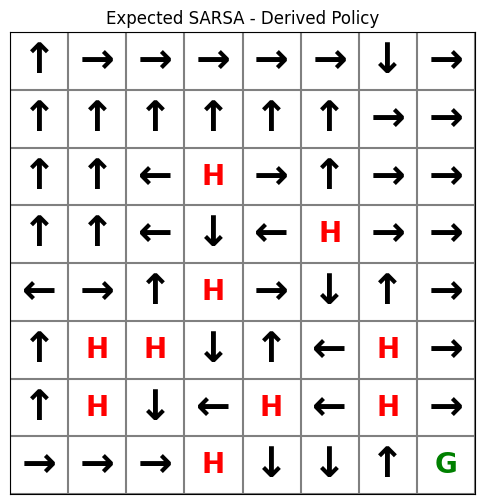

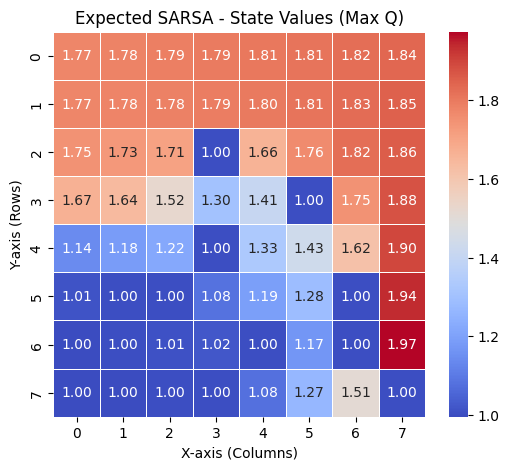

877.0


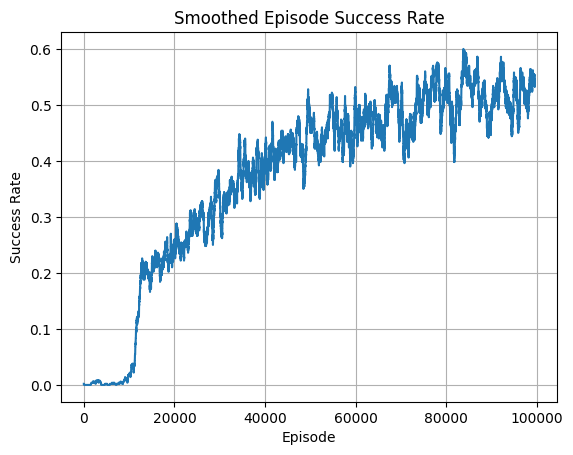

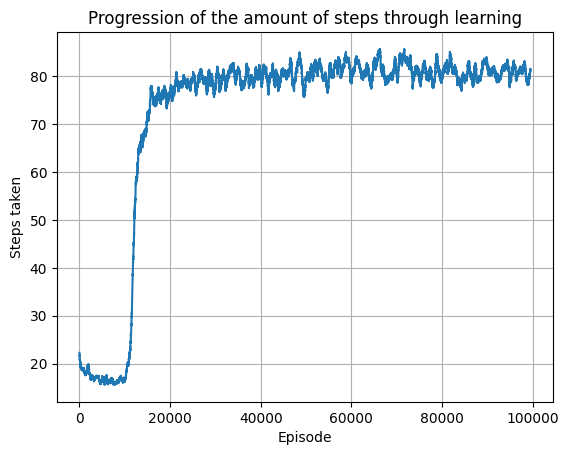

In [48]:
policy_expected = derive_policy(Q_expected)
plot_policy(policy_expected, env, title="Expected SARSA - Derived Policy")
plot_state_values(np.max(Q_expected, axis=1), title="Expected SARSA - State Values (Max Q)")

res = evaluate_policy(env, policy_expected, episodes=1000)
print(sum(res))

plot_rewards(episode_rewards, window_size=500)

plot_steps(steps, window_size=500)


### Q-Learning

In [42]:
gamma_qlearn = 0.999        # Q-Learning: discount factor
episodes_qlearn = 100000    # Q-Learning: number of episodes
epsilon_qlearn = 1.0      # Q-Learning: initial epsilon
alpha_qlearn = 0.05       # Q-Learning: learning rate

Q_qlearn, episode_rewards, steps = q_learning(env, alpha=alpha_qlearn, gamma=gamma_qlearn, epsilon=epsilon_qlearn, episodes=episodes_qlearn)

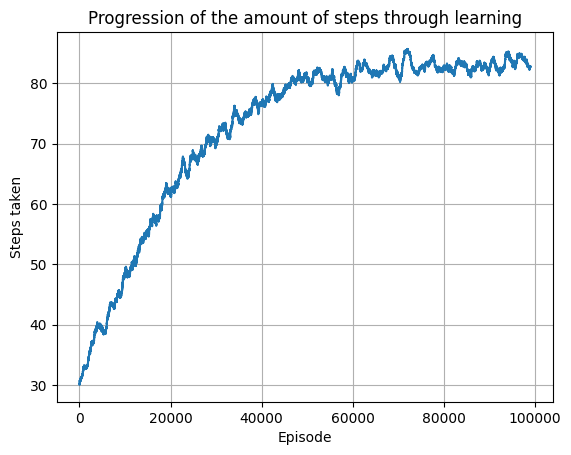

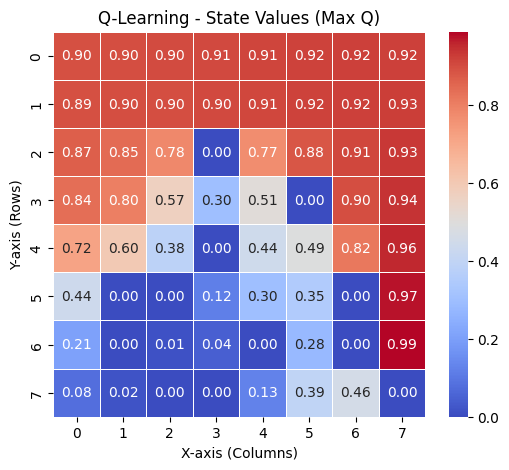

885.0


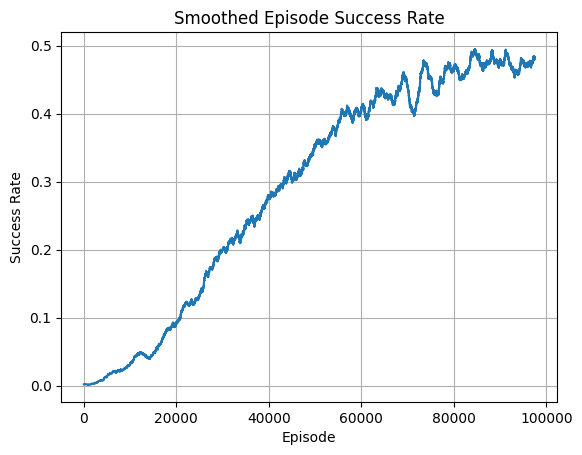

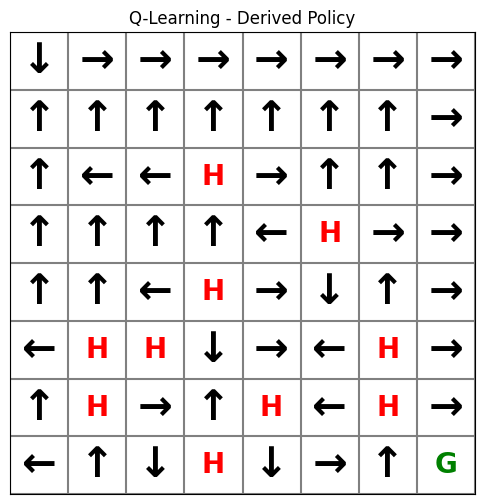

In [44]:

plot_steps(steps, window_size=1000)
policy_qlearn = derive_policy(Q_qlearn)
plot_state_values(np.max(Q_qlearn, axis=1), title="Q-Learning - State Values (Max Q)")

res = evaluate_policy(env, policy_qlearn, episodes=1000)
print(sum(res))

plot_rewards(episode_rewards, window_size=2500)
plot_policy(policy_qlearn, env, title="Q-Learning - Derived Policy")
